<a href="https://colab.research.google.com/github/Fazin/mba-data-science-usp/blob/main/TCC_MBA_Data_Science_%26_Analytics_Fabricio_Passos.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# TCC - Clustering e otimização de rotas para logística de entrega nas vias da cidade de São Paulo

## Parte 1 - Tratamento de Dados e Agrupamentos de rotas

### Bibliotecas

In [ ]:
import numpy as np
import pandas as pd
import shapefile as shp
import matplotlib.pyplot as plt
import seaborn as sns
import geopandas as gpd
from shapely.geometry import Point, Polygon
from geopandas import GeoDataFrame
import fiona
from sklearn.cluster import KMeans
from tqdm import tqdm


### Coleta de Dados

#### Amostra de pontos

In [ ]:
df_pontos = pd.read_csv('files/amostra_dados.csv')[['la_0',	'lo_0']]
df_pontos

la_0       lo_0
0     -23.657146 -46.775967
1     -23.633581 -46.729430
2     -23.607645 -46.801768
3     -23.604415 -46.795938
4     -23.604415 -46.795938
...          ...        ...
11995 -23.527303 -46.698475
11996 -23.515473 -46.688102
11997 -23.525058 -46.730732
11998 -23.487957 -46.753281
11999 -23.511676 -46.714492

[12000 rows x 2 columns]

In [ ]:
sns.set(style="whitegrid", palette="pastel", color_codes=True)
sns.mpl.rc("figure", figsize=(10,6))

#### Grupo de poligonos da cidade de São Paulo

In [ ]:
try:
    sp = gpd.read_file('files/3550308_Sao Paulo_Setores_2020.kml', driver='KML')
except:
    gpd.io.file.fiona.drvsupport.supported_drivers['KML'] = 'rw'
    sp = gpd.read_file('files/3550308_Sao Paulo_Setores_2020.kml', driver='KML')
sp.head()

Name                                        Description  \
0  355030881000513  <center><table><tr><th colspan='2' align='cent...   
1  355030881000512  <center><table><tr><th colspan='2' align='cent...   
2  355030881000510  <center><table><tr><th colspan='2' align='cent...   
3  355030881000485  <center><table><tr><th colspan='2' align='cent...   
4  355030881000484  <center><table><tr><th colspan='2' align='cent...   

                                            geometry  
0  POLYGON Z ((-46.58348 -23.42321 0.00000, -46.5...  
1  POLYGON Z ((-46.58837 -23.42523 0.00000, -46.5...  
2  POLYGON Z ((-46.57875 -23.37375 0.00000, -46.5...  
3  POLYGON Z ((-46.61870 -23.44363 0.00000, -46.6...  
4  POLYGON Z ((-46.59404 -23.42785 0.00000, -46.5...

In [ ]:
i=0
for poly in tqdm(sp['geometry']):
    if i==0:
        poly_sp = poly
        i+=1
    else:
        poly_sp = poly_sp.union(poly)

100%|██████████| 27411/27411 [10:03<00:00, 45.38it/s]


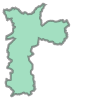

In [ ]:
poly_sp

#### Função e filtro de pontos fora do polígono de São Paulo

In [ ]:
def checkpolygon(poly,point):
    if poly.contains(point):
        return True
    else:
        return False


In [ ]:
geometry = [ Point(xy) for xy in zip(df_pontos['lo_0'],df_pontos['la_0']) ]
gdf = GeoDataFrame(df_pontos, geometry=geometry, crs='epsg:4326')

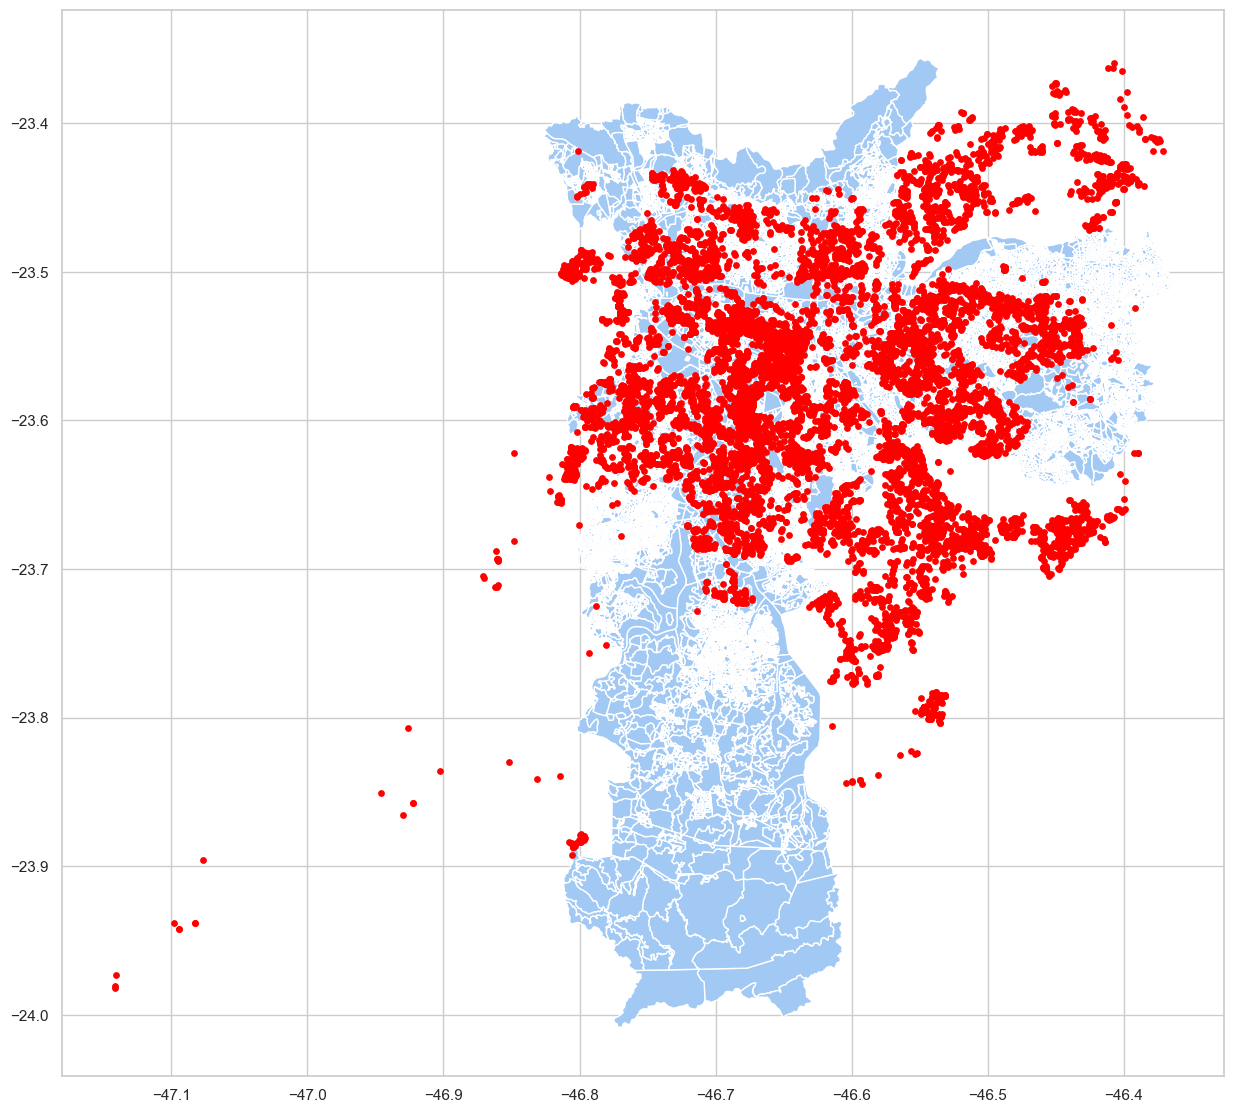

In [ ]:
# world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))

gdf.plot(ax=sp.plot(figsize=(15, 15)), marker='o', color='red',markersize=15)
plt.show()


In [ ]:
gdf

la_0       lo_0                     geometry
0     -23.657146 -46.775967  POINT (-46.77597 -23.65715)
1     -23.633581 -46.729430  POINT (-46.72943 -23.63358)
2     -23.607645 -46.801768  POINT (-46.80177 -23.60765)
3     -23.604415 -46.795938  POINT (-46.79594 -23.60442)
4     -23.604415 -46.795938  POINT (-46.79594 -23.60442)
...          ...        ...                          ...
11995 -23.527303 -46.698475  POINT (-46.69848 -23.52730)
11996 -23.515473 -46.688102  POINT (-46.68810 -23.51547)
11997 -23.525058 -46.730732  POINT (-46.73073 -23.52506)
11998 -23.487957 -46.753281  POINT (-46.75328 -23.48796)
11999 -23.511676 -46.714492  POINT (-46.71449 -23.51168)

[12000 rows x 3 columns]

In [ ]:
from tqdm import tqdm
flag_list = []
for geo in tqdm(gdf['geometry']):
    flag_list.append(checkpolygon(poly_sp,geo))

100%|██████████| 12000/12000 [00:11<00:00, 1047.87it/s]


In [ ]:
gdf['flag_sp'] = flag_list

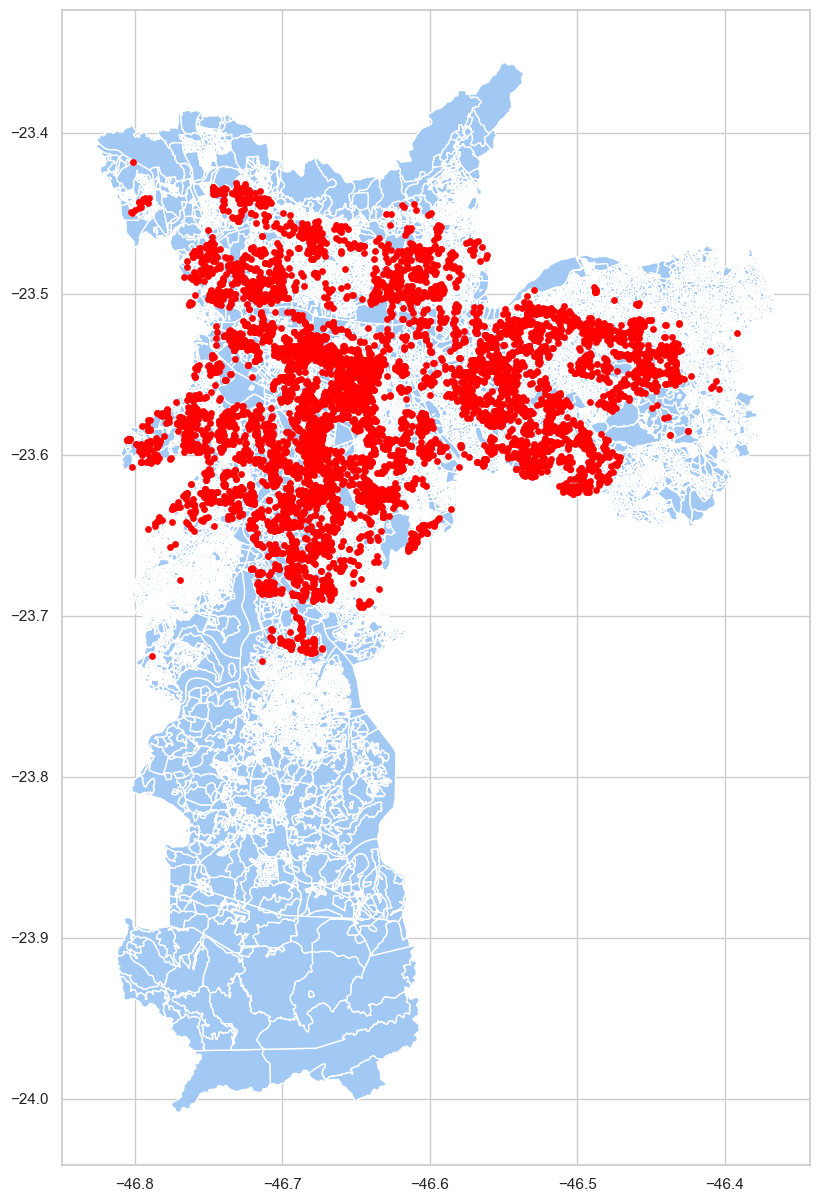

In [ ]:

gdf[gdf['flag_sp'] == 1].plot(ax=sp.plot(figsize=(15, 15)), marker='o', color='red',markersize=15)
plt.show()


In [ ]:
gdf = gdf[gdf['flag_sp'] == 1]

In [ ]:
features = gdf[gdf['flag_sp']==1][['la_0', 'lo_0']]

#### Grupo de cores para agrupamentos no gráfico

In [ ]:
colors = ['green', 'blue', 'yellow', 'orange', 'purple', 'pink', 'brown', 'black', 'gray', 'olive', 'cyan', 'magenta', 'indigo', 'navy', 'maroon', 'lime', 'teal', 'coral', 'crimson', 'gold', 'silver', 'aqua', 'limegreen', 'lightcoral', 'lightblue', 'lightgreen', 'lightgray', 'lightpink', 'lightsalmon', 'lightseagreen', 'lightskyblue', 'lightslategray', 'lightsteelblue', 'lightyellow', 'mediumaquamarine', 'mediumblue', 'mediumorchid', 'mediumpurple', 'mediumseagreen', 'mediumslateblue', 'mediumspringgreen', 'mediumturquoise', 'mediumvioletred', 'midnightblue', 'mintcream', 'mistyrose', 'moccasin', 'navajowhite', 'oldlace', 'olivedrab', 'orangered', 'orchid', 'palegoldenrod', 'palegreen', 'paleturquoise', 'palevioletred', 'papayawhip', 'peachpuff', 'peru', 'pink', 'plum', 'powderblue', 'rosybrown', 'royalblue', 'saddlebrown', 'salmon', 'sandybrown', 'seagreen', 'seashell', 'sienna', 'skyblue', 'slateblue', 'slategray', 'snow', 'springgreen', 'steelblue', 'tan', 'thistle', 'tomato', 'turquoise', 'violet', 'wheat', 'whitesmoke', 'yellowgreen']
color_dict = {i: colors[i] for i in range(len(colors))}
color_dict

{0: 'green',
 1: 'blue',
 2: 'yellow',
 3: 'orange',
 4: 'purple',
 5: 'pink',
 6: 'brown',
 7: 'black',
 8: 'gray',
 9: 'olive',
 10: 'cyan',
 11: 'magenta',
 12: 'indigo',
 13: 'navy',
 14: 'maroon',
 15: 'lime',
 16: 'teal',
 17: 'coral',
 18: 'crimson',
 19: 'gold',
 20: 'silver',
 21: 'aqua',
 22: 'limegreen',
 23: 'lightcoral',
 24: 'lightblue',
 25: 'lightgreen',
 26: 'lightgray',
 27: 'lightpink',
 28: 'lightsalmon',
 29: 'lightseagreen',
 30: 'lightskyblue',
 31: 'lightslategray',
 32: 'lightsteelblue',
 33: 'lightyellow',
 34: 'mediumaquamarine',
 35: 'mediumblue',
 36: 'mediumorchid',
 37: 'mediumpurple',
 38: 'mediumseagreen',
 39: 'mediumslateblue',
 40: 'mediumspringgreen',
 41: 'mediumturquoise',
 42: 'mediumvioletred',
 43: 'midnightblue',
 44: 'mintcream',
 45: 'mistyrose',
 46: 'moccasin',
 47: 'navajowhite',
 48: 'oldlace',
 49: 'olivedrab',
 50: 'orangered',
 51: 'orchid',
 52: 'palegoldenrod',
 53: 'palegreen',
 54: 'paleturquoise',
 55: 'palevioletred',
 56: 'papa

### Agrupamentos dos pontos

#### Aplicação da clusterização k-means para analise e controle

In [ ]:
distortions = []
K = range(1,20)
for k in K:
    kmeanModel = KMeans(n_clusters=k, n_init=k)
    kmeanModel.fit(features)
    distortions.append(kmeanModel.inertia_)

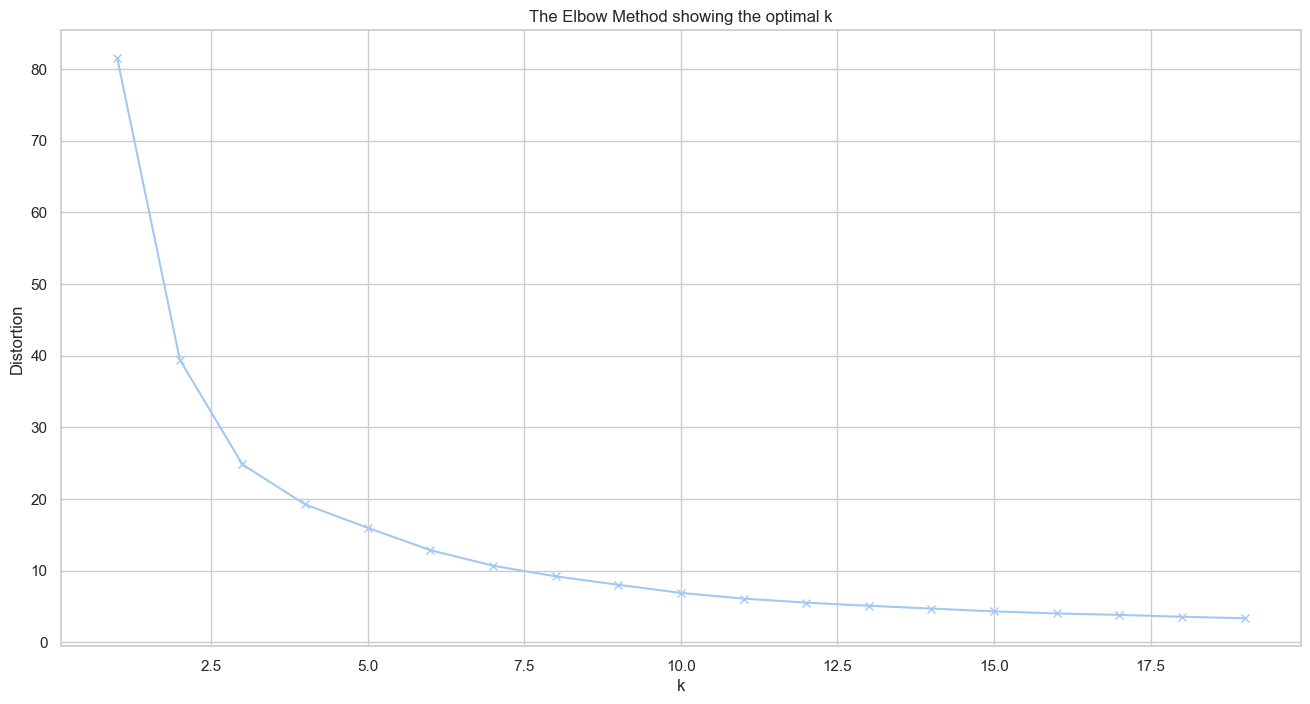

In [ ]:
plt.figure(figsize=(16,8))
plt.plot(K, distortions, 'bx-')
plt.xlabel('k')
plt.ylabel('Distortion')
plt.title('The Elbow Method showing the optimal k')
plt.show()

In [ ]:

# create kmeans model/object
kmeans = KMeans(
    init="random",
    n_clusters=10,
    n_init=10,
    max_iter=300,
    random_state=42
)

In [ ]:
# do clustering
kmeans.fit(features)
# save results
labels = kmeans.labels_

In [ ]:
# send back into dataframe and display it
gdf['cluster'] = labels
gdf['color'] = gdf['cluster'].map(color_dict)
# display the number of mamber each clustering
_clusters = gdf.groupby('cluster').count()
print(_clusters)
_clusters.describe()

         la_0  lo_0  geometry  flag_sp  color
cluster                                      
0         662   662       662      662    662
1         518   518       518      518    518
2         496   496       496      496    496
3        1242  1242      1242     1242   1242
4         698   698       698      698    698
5        1135  1135      1135     1135   1135
6         554   554       554      554    554
7         891   891       891      891    891
8        1714  1714      1714     1714   1714
9         651   651       651      651    651


/Users/fpassos/Documents/MBA/TCC/code/venv/lib/python3.9/site-packages/geopandas/geodataframe.py:1443: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)
/Users/fpassos/Documents/MBA/TCC/code/venv/lib/python3.9/site-packages/geopandas/geodataframe.py:1443: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)


la_0         lo_0     geometry      flag_sp        color
count    10.000000    10.000000    10.000000    10.000000    10.000000
mean    856.100000   856.100000   856.100000   856.100000   856.100000
std     394.954132   394.954132   394.954132   394.954132   394.954132
min     496.000000   496.000000   496.000000   496.000000   496.000000
25%     578.250000   578.250000   578.250000   578.250000   578.250000
50%     680.000000   680.000000   680.000000   680.000000   680.000000
75%    1074.000000  1074.000000  1074.000000  1074.000000  1074.000000
max    1714.000000  1714.000000  1714.000000  1714.000000  1714.000000

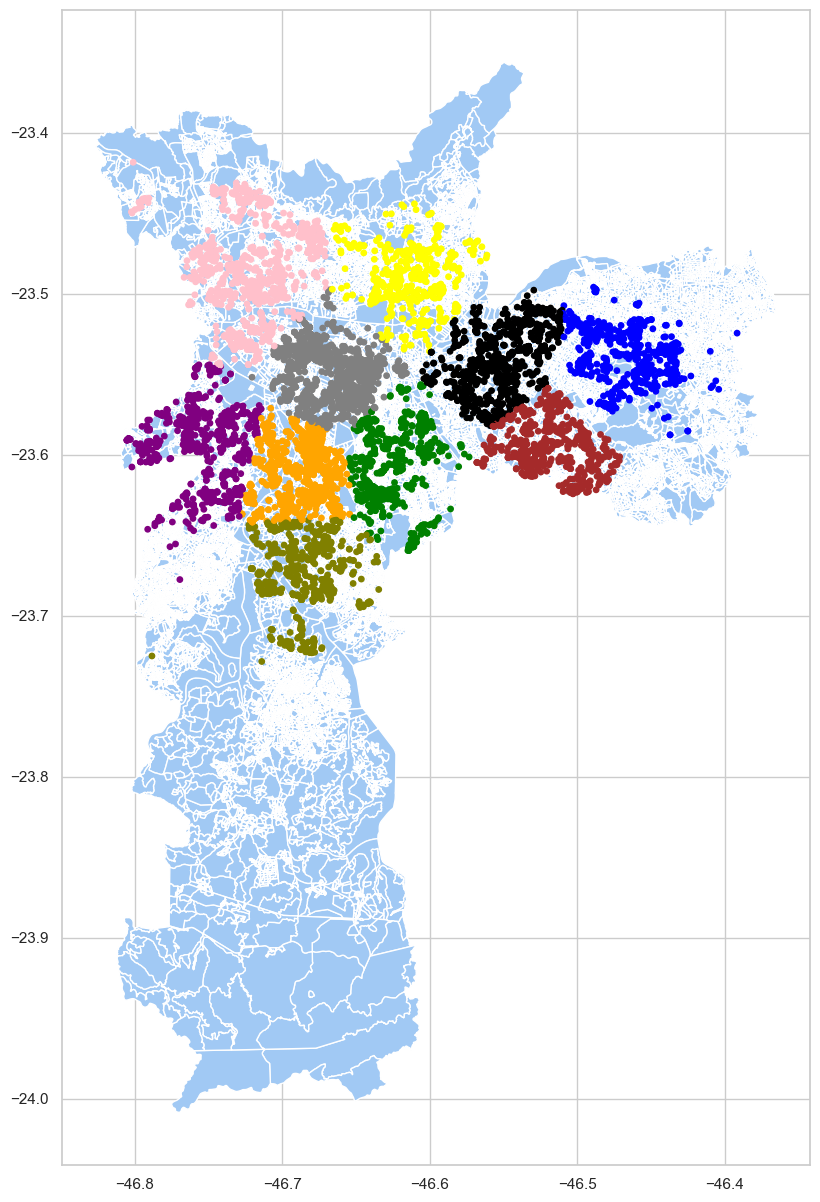

In [ ]:
gdf.plot(ax=sp.plot(figsize=(15, 15)), marker='o', color=gdf['color'],markersize=15)
plt.show()

#### Aplicação do DBSCAN

In [ ]:
import numpy as np
from sklearn.cluster import DBSCAN
from sklearn.metrics.pairwise import haversine_distances

In [ ]:
# define the data points
gdf_points = gdf[['la_0', 'lo_0']].values

In [ ]:

# define the epsilon and minimum samples hyperparameters
min_samples = 30 # adjust based on the desired minimum cluster size
kms_per_radian = 6371.0088
epsilon = 1 / kms_per_radian # in degrees, adjust based on distance between points
# fit the DBSCAN clustering algorithm
db = DBSCAN(eps=epsilon, min_samples=min_samples, algorithm='ball_tree', metric='haversine').fit(np.radians(gdf_points))


# retrieve the labels and number of clusters
labels = db.labels_
n_clusters = len(set(labels)) - (1 if -1 in labels else 0)

# print the results
print('Number of clusters: {}'.format(n_clusters))
# print('Cluster labels: {}'.format(labels))



Number of clusters: 11


In [ ]:
gdf['dbscan_cluster']=labels+1
gdf['dbscan_color'] = gdf['dbscan_cluster'].map(color_dict)

/Users/fpassos/Documents/MBA/TCC/code/venv/lib/python3.9/site-packages/geopandas/geodataframe.py:1443: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)
/Users/fpassos/Documents/MBA/TCC/code/venv/lib/python3.9/site-packages/geopandas/geodataframe.py:1443: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)


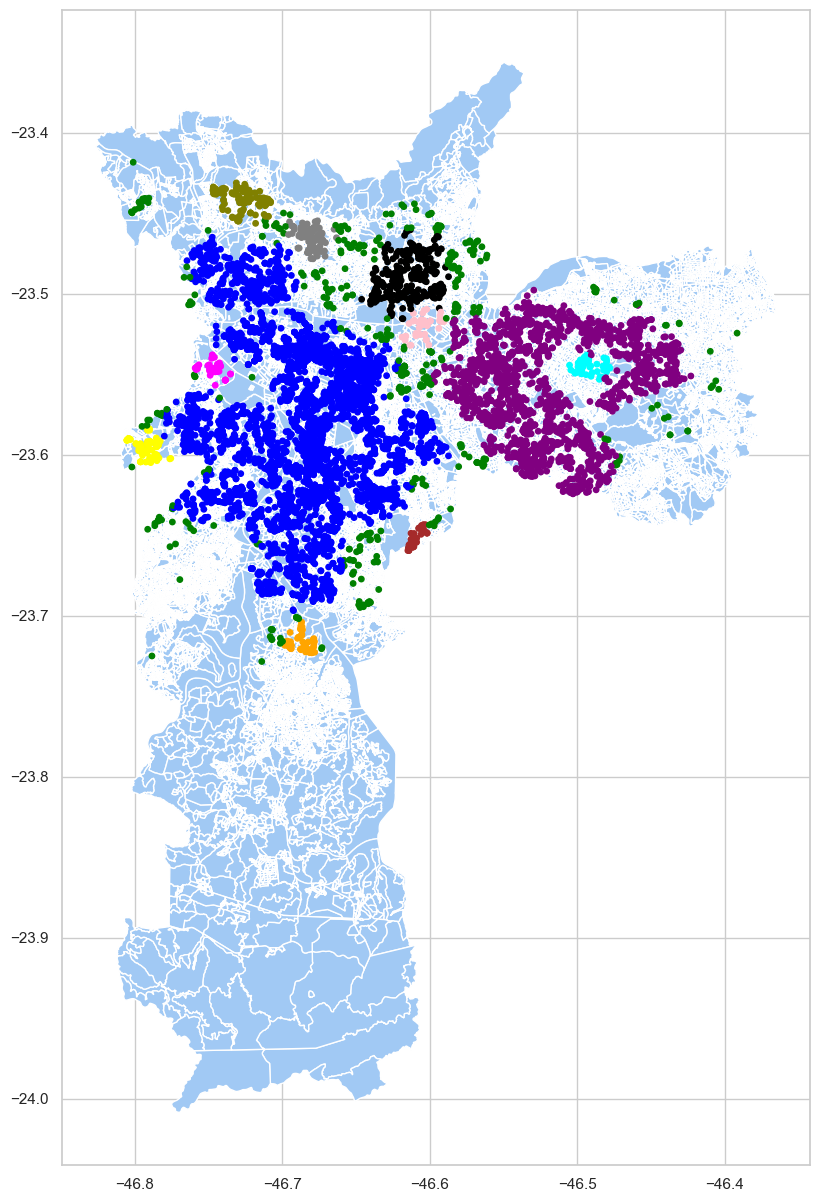

In [ ]:
gdf.plot(ax=sp.plot(figsize=(15, 15)), marker='o', color=gdf['dbscan_color'],markersize=15)
plt.show()

In [ ]:
# display the number of mamber each clustering
_clusters2 = gdf.groupby('dbscan_color').count()
print(_clusters2)
_clusters2.describe()

              la_0  lo_0  geometry  flag_sp  cluster  color  dbscan_cluster
dbscan_color                                                               
black          317   317       317      317      317    317             317
blue          5415  5415      5415     5415     5415   5415            5415
brown           38    38        38       38       38     38              38
cyan            51    51        51       51       51     51              51
gray            82    82        82       82       82     82              82
green          454   454       454      454      454    454             454
magenta         46    46        46       46       46     46              46
olive          132   132       132      132      132    132             132
orange          51    51        51       51       51     51              51
pink            53    53        53       53       53     53              53
purple        1840  1840      1840     1840     1840   1840            1840
yellow      

la_0         lo_0     geometry      flag_sp      cluster  \
count    12.000000    12.000000    12.000000    12.000000    12.000000   
mean    713.416667   713.416667   713.416667   713.416667   713.416667   
std    1565.227631  1565.227631  1565.227631  1565.227631  1565.227631   
min      38.000000    38.000000    38.000000    38.000000    38.000000   
25%      51.000000    51.000000    51.000000    51.000000    51.000000   
50%      82.000000    82.000000    82.000000    82.000000    82.000000   
75%     351.250000   351.250000   351.250000   351.250000   351.250000   
max    5415.000000  5415.000000  5415.000000  5415.000000  5415.000000   

             color  dbscan_cluster  
count    12.000000       12.000000  
mean    713.416667      713.416667  
std    1565.227631     1565.227631  
min      38.000000       38.000000  
25%      51.000000       51.000000  
50%      82.000000       82.000000  
75%     351.250000      351.250000  
max    5415.000000     5415.000000

#### Agrupando um unico grupo para determinar as rotas

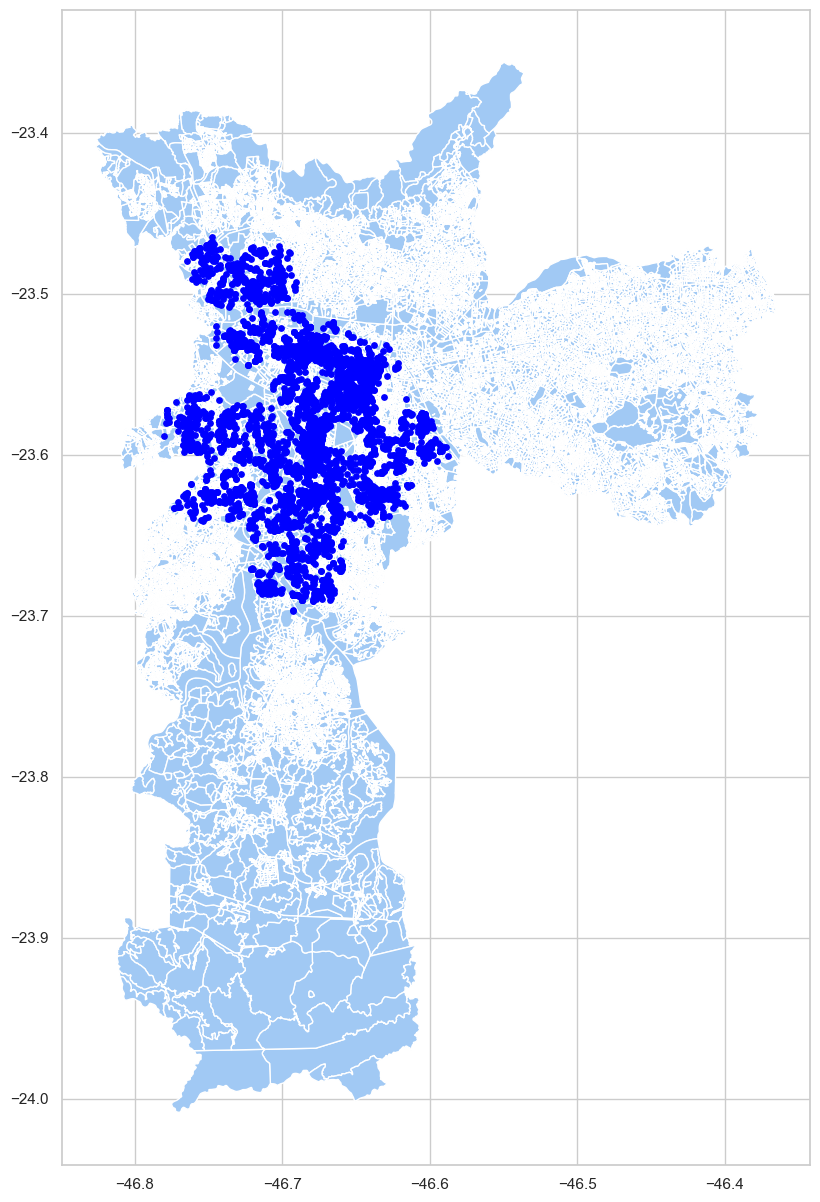

In [ ]:
gdf[gdf['dbscan_cluster'] == 1].plot(ax=sp.plot(figsize=(15, 15)), marker='o', color='blue',markersize=15)
plt.show()

In [ ]:
gdf_dbscan1 = gdf[gdf['dbscan_cluster'] == 1]

In [ ]:
features_2 = gdf_dbscan1[['la_0', 'lo_0']]

In [ ]:
distortions_2 = []
K = range(1,20)
for k in K:
    kmeanModel = KMeans(n_clusters=k, n_init=k)
    kmeanModel.fit(features_2)
    distortions_2.append(kmeanModel.inertia_)

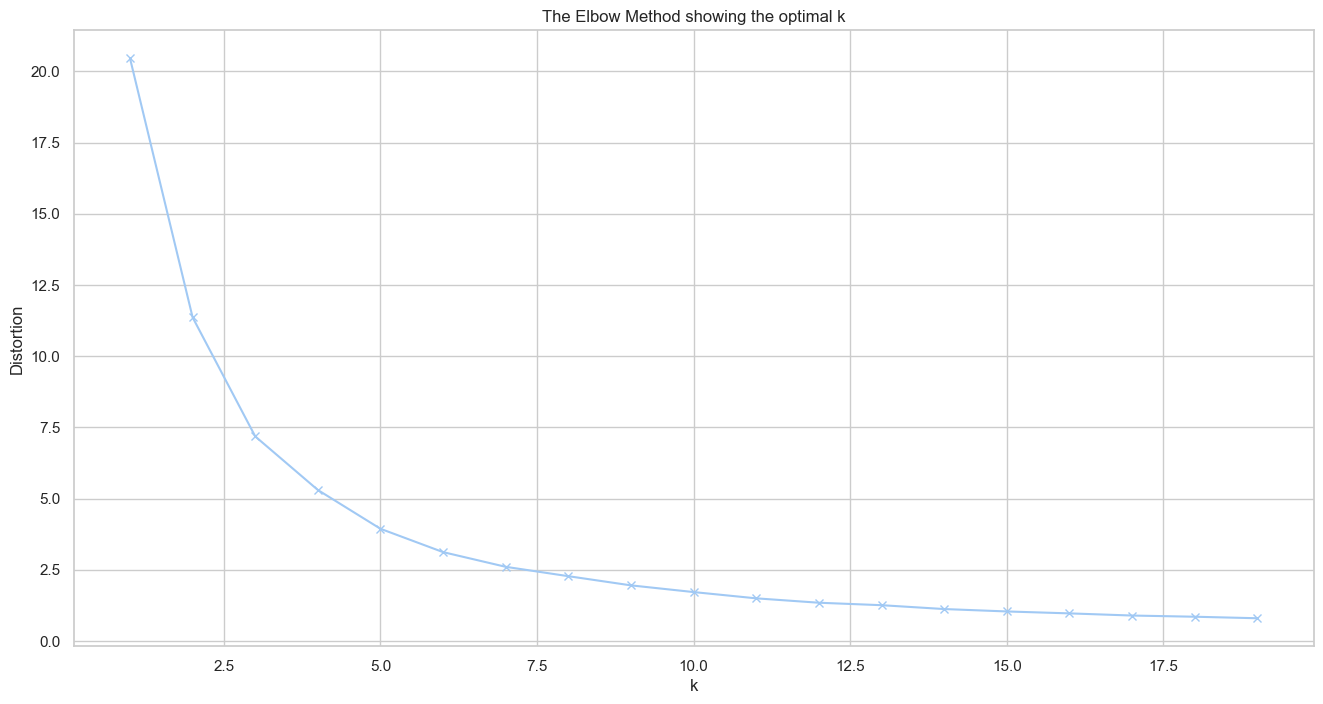

In [ ]:
plt.figure(figsize=(16,8))
plt.plot(K, distortions_2, 'bx-')
plt.xlabel('k')
plt.ylabel('Distortion')
plt.title('The Elbow Method showing the optimal k')
plt.show()

In [ ]:

# create kmeans model/object
kmeans_2 = KMeans(
    init="random",
    n_clusters=10,
    n_init=10,
    max_iter=300,
    random_state=42
)

In [ ]:
# do clustering
kmeans_2.fit(features_2)
# save results
labels_2 = kmeans_2.labels_

In [ ]:
# send back into dataframe and display it
gdf_dbscan1['cluster_2'] = labels_2
gdf_dbscan1['color_2'] = gdf_dbscan1['cluster_2'].map(color_dict)
# display the number of mamber each clustering
_clusters = gdf_dbscan1.groupby('color_2').count()
print(_clusters)
_clusters.describe()

         la_0  lo_0  geometry  flag_sp  cluster  color  dbscan_cluster  \
color_2                                                                  
black     660   660       660      660      660    660             660   
blue      308   308       308      308      308    308             308   
brown     833   833       833      833      833    833             833   
gray      511   511       511      511      511    511             511   
green     465   465       465      465      465    465             465   
olive     484   484       484      484      484    484             484   
orange    390   390       390      390      390    390             390   
pink      379   379       379      379      379    379             379   
purple    685   685       685      685      685    685             685   
yellow    700   700       700      700      700    700             700   

         dbscan_color  cluster_2  
color_2                           
black             660        660  
blue  

/Users/fpassos/Documents/MBA/TCC/code/venv/lib/python3.9/site-packages/geopandas/geodataframe.py:1443: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)
/Users/fpassos/Documents/MBA/TCC/code/venv/lib/python3.9/site-packages/geopandas/geodataframe.py:1443: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)


la_0        lo_0    geometry     flag_sp     cluster       color  \
count   10.000000   10.000000   10.000000   10.000000   10.000000   10.000000   
mean   541.500000  541.500000  541.500000  541.500000  541.500000  541.500000   
std    169.541375  169.541375  169.541375  169.541375  169.541375  169.541375   
min    308.000000  308.000000  308.000000  308.000000  308.000000  308.000000   
25%    408.750000  408.750000  408.750000  408.750000  408.750000  408.750000   
50%    497.500000  497.500000  497.500000  497.500000  497.500000  497.500000   
75%    678.750000  678.750000  678.750000  678.750000  678.750000  678.750000   
max    833.000000  833.000000  833.000000  833.000000  833.000000  833.000000   

       dbscan_cluster  dbscan_color   cluster_2  
count       10.000000     10.000000   10.000000  
mean       541.500000    541.500000  541.500000  
std        169.541375    169.541375  169.541375  
min        308.000000    308.000000  308.000000  
25%        408.750000    408.750000  408.750000  
50%        497.500000    497.500000  497.500000  
75%        678.750000    678.750000  678.750000  
max        833.000000    833.000000  833.000000

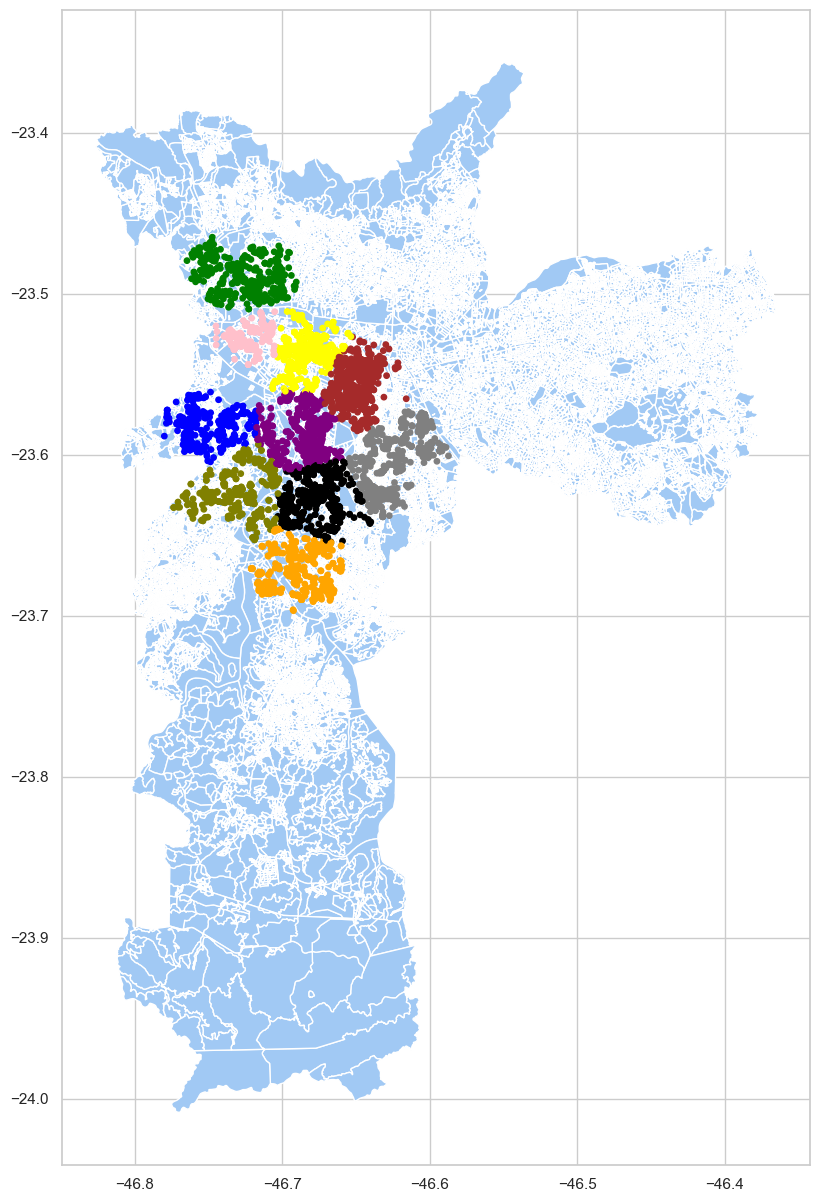

In [ ]:
gdf_dbscan1.plot(ax=sp.plot(figsize=(15, 15)), marker='o', color=gdf_dbscan1['color_2'],markersize=15)
plt.show()

In [ ]:
gdf_dbscan1

la_0       lo_0                     geometry  flag_sp  cluster  \
1     -23.633581 -46.729430  POINT (-46.72943 -23.63358)     True        4   
10    -23.578434 -46.673542  POINT (-46.67354 -23.57843)     True        8   
11    -23.587010 -46.680395  POINT (-46.68039 -23.58701)     True        3   
12    -23.578263 -46.673697  POINT (-46.67370 -23.57826)     True        8   
13    -23.601890 -46.674755  POINT (-46.67475 -23.60189)     True        3   
...          ...        ...                          ...      ...      ...   
11995 -23.527303 -46.698475  POINT (-46.69848 -23.52730)     True        8   
11996 -23.515473 -46.688102  POINT (-46.68810 -23.51547)     True        5   
11997 -23.525058 -46.730732  POINT (-46.73073 -23.52506)     True        5   
11998 -23.487957 -46.753281  POINT (-46.75328 -23.48796)     True        5   
11999 -23.511676 -46.714492  POINT (-46.71449 -23.51168)     True        5   

        color  dbscan_cluster dbscan_color  cluster_2 color_2  
1      purple               1         blue          9   olive  
10       gray               1         blue          4  purple  
11     orange               1         blue          4  purple  
12       gray               1         blue          4  purple  
13     orange               1         blue          4  purple  
...       ...             ...          ...        ...     ...  
11995    gray               1         blue          2  yellow  
11996    pink               1         blue          2  yellow  
11997    pink               1         blue          5    pink  
11998    pink               1         blue          0   green  
11999    pink               1         blue          5    pink  

[5415 rows x 10 columns]

In [ ]:
gdf_dbscan1.to_csv("files/gdf_dbscan1.csv", index=False)